# GNN for Link + Vote Prediction with sliding window training

This notebook trains a **Hierarchical Graph Neural Network** to predict link existance and vote polarity simultaneously.

In this variant we explore the **sliding window training approach**, which consists in:

- firstly consider a window of fixed size W
- split the window in training, validation and test sets and perform training and evaluation
- then move the window by a step size S
- this approach until now **do not** use the concept of continual learning


## Setup

In [2]:
# Import standard libraries
import sys
from pathlib import Path
from collections import Counter
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Data handling
import pandas as pd
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler, train_val_test_split_by_date
from utility import sum_months, analyze_split_statistics

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [3]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [4]:
# Encode users as numerical IDs
users = list(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('Richard n', np.int64(8047)), ('Kertrats', np.int64(5283)), ('Shirik', np.int64(8653)), ('No qwach macken', np.int64(6932)), ('Irishpunktom', np.int64(4527)), ('Dlyons493', np.int64(2682)), ('PRODUCER', np.int64(7237)), ('luvcraft', np.int64(10963)), ('Mauler90', np.int64(6144)), ('Carba', np.int64(1667))]


In [5]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Generate windows

In [6]:
def get_sliding_windows(X: torch.Tensor, y: torch.Tensor, dates: np.ndarray, window_size_months=36, step_size_months=6, val_months=6, test_months=6):
    """
    Generate time-based train/val/test splits for each window.
    Args:
        X (torch.Tensor): Edge list tensor of shape (num_edges, 2).
        y (torch.Tensor): Labels tensor of shape (num_edges,).
        dates (np.ndarray): Array of dates corresponding to each edge.
        window_size_months (int): Size of each time window in months.
        step_size_months (int): Step size to move the window in months.
        val_months (int): Number of months for the validation set.
        test_months (int): Number of months for the test set.
    Yields:
        Tuples of (X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test) for each time window.
    """
    current_start = min(dates)

    while True:
        current_end = sum_months(current_start, window_size_months)
        
        if current_end > max(dates):
            print("Reached the end of the date range. Discarded window:", current_start, "->", current_end)
            break
        
        # Extract the window
        mask_window = (dates >= current_start) & (dates < current_end)
        # If the window is empty, skip it
        if not np.any(mask_window):
            current_start = sum_months(current_start, step_size_months)
            continue

        # Internal splitting
        yield train_val_test_split_by_date(
            X[mask_window],
            y[mask_window],
            dates[mask_window],
            val_months=val_months,
            test_months=test_months
        )
        
        # Go to the next window
        current_start = sum_months(current_start, step_size_months)

def get_increasing_windows(X: torch.Tensor, y: torch.Tensor, dates: np.ndarray, window_size_months=24, val_months=6, test_months=6):
    """
    Generate time-based train/val/test splits for each increasing window.
    Args:
        X (torch.Tensor): Edge list tensor of shape (num_edges, 2).
        y (torch.Tensor): Labels tensor of shape (num_edges,).
        dates (np.ndarray): Array of dates corresponding to each edge.
        window_size_months (int): Size of first time window in months.
        val_months (int): Number of months for the validation set.
        test_months (int): Number of months for the test set.
    Yields:
        Tuples of (X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test) for each time window.
    """
    current_start = min(dates)

    while True:
        current_end = sum_months(current_start, window_size_months)

        if current_end > max(dates):
            print("Reached the end of the date range. Discarded window:", current_start, "->", current_end)
            break
        
        # Extract the window
        mask_window = (dates < current_end)
        # If the window is empty, skip it
        if not np.any(mask_window):
            current_end = sum_months(current_end, val_months + test_months)
            continue

        # Internal splitting
        yield train_val_test_split_by_date(
            X[mask_window],
            y[mask_window],
            dates[mask_window],
            val_months=val_months,
            test_months=test_months
        )

Reached the end of the date range. Discarded window: 20100816 -> 20130816
    Total_Size        Train_Interval          Val_Interval         Test_Interval
0        52168  (20030816, 20050814)  (20050815, 20060214)  (20060215, 20060815)
1        71369  (20040216, 20060214)  (20060215, 20060814)  (20060815, 20070215)
2        88760  (20040816, 20060814)  (20060815, 20070214)  (20070215, 20070815)
3       106034  (20050216, 20070214)  (20070215, 20070814)  (20070815, 20080215)
4       117673  (20050816, 20070814)  (20070815, 20080214)  (20080215, 20080815)
5       110467  (20060216, 20080214)  (20080215, 20080814)  (20080815, 20090215)
6        96891  (20060816, 20080814)  (20080815, 20090214)  (20090215, 20090815)
7        87371  (20070216, 20090214)  (20090215, 20090814)  (20090815, 20100215)
8        74046  (20070816, 20090814)  (20090815, 20100214)  (20100215, 20100815)
9        60723  (20080216, 20100214)  (20100215, 20100814)  (20100815, 20110215)
10       49709  (20080816, 20100814

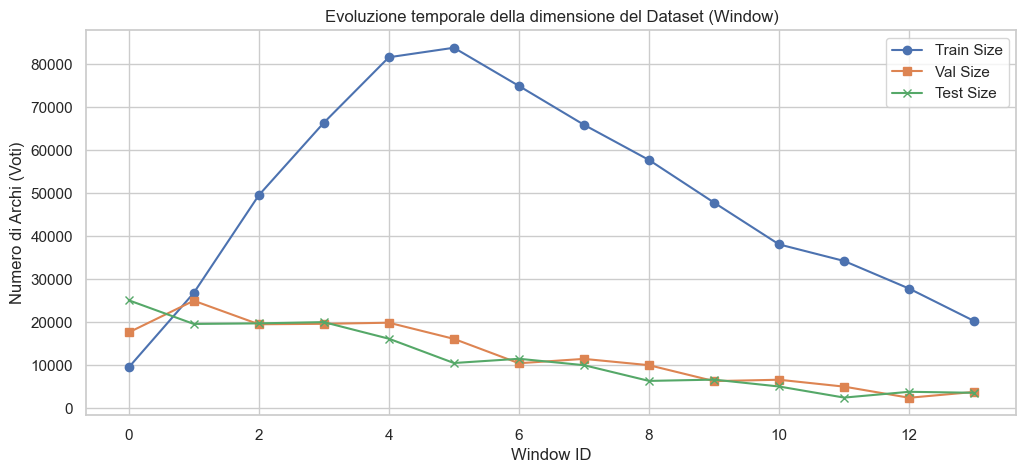

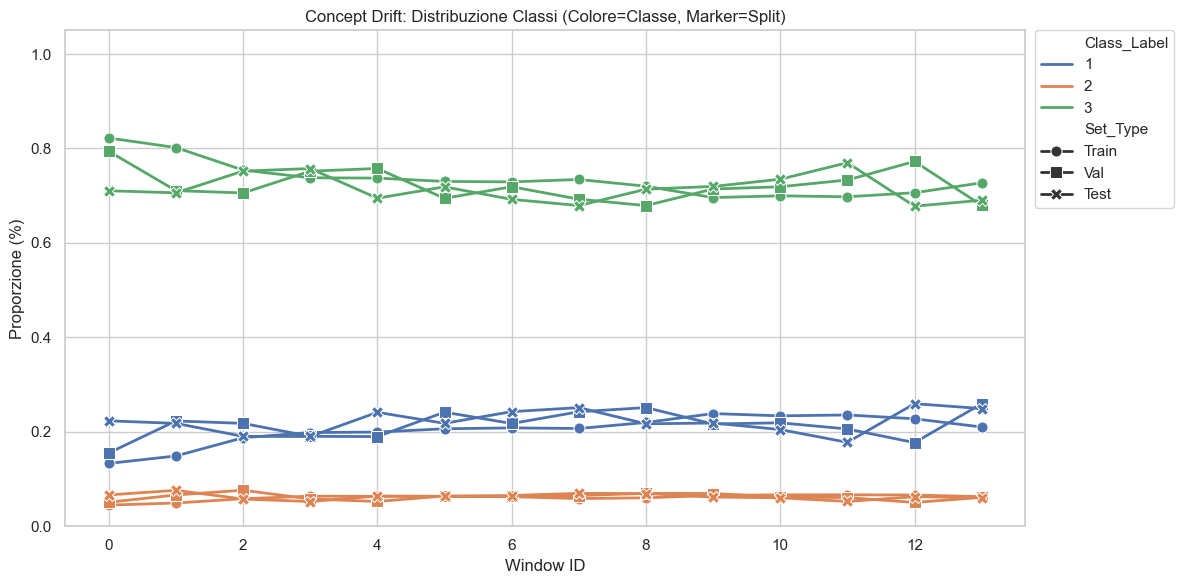

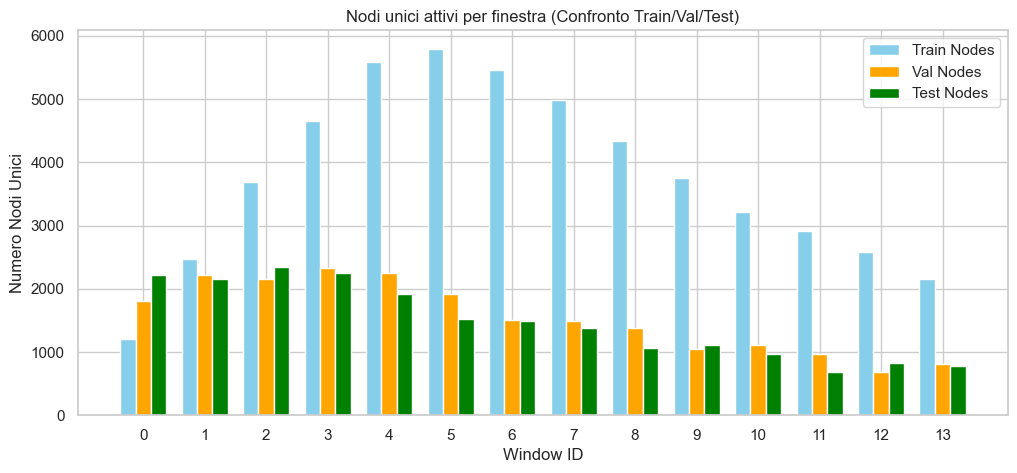

In [7]:
def analyze_windows(window_generator):
    """
    Consuma il generatore di finestre e calcola statistiche dettagliate.
    Args:
        window_generator: Il generatore di windows
    Returns:
        pd.DataFrame: DataFrame contenente le statistiche per ogni finestra.
    """
    stats_list = []
    
    for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(window_generator):
        
        # Calcolo distribuzioni delle classi
        train_counts = Counter(y_tr.numpy())
        val_counts = Counter(y_va.numpy())
        test_counts = Counter(y_te.numpy())
        
        # Calcolo nodi unici attivi (Voters + Candidates)
        train_unique_nodes = len(np.unique(X_tr.numpy()))
        val_unique_nodes = len(np.unique(X_va.numpy()))
        test_unique_nodes = len(np.unique(X_te.numpy()))
        
        # Struttura dati per il DataFrame
        row = {
            'Window_ID': i,
            'Train_Size': len(y_tr),
            'Val_Size': len(y_va),
            'Test_Size': len(y_te),
            'Total_Size': len(y_tr) + len(y_va) + len(y_te),
            'Train_Interval': (min(dates_tr), max(dates_tr)),
            'Val_Interval': (min(dates_va), max(dates_va)),
            'Test_Interval': (min(dates_te), max(dates_te)),
            'Train_Unique_Nodes': train_unique_nodes,
            'Val_Unique_Nodes': val_unique_nodes,
            'Test_Unique_Nodes': test_unique_nodes,
            'Train_Ratio': len(y_tr) / (len(y_tr) +len(y_va) + len(y_te)),
            'Val_Ratio': len(y_va) / (len(y_tr) + len(y_va) + len(y_te)),
            'Test_Ratio': len(y_te) / (len(y_tr) + len(y_va) + len(y_te))
        }
        
        # Aggiungiamo le info sulle classi in colonne separate (es. Train_Class_0, Train_Class_1...)
        all_classes = set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys()))
        for cls in sorted(all_classes):
            row[f'Train_Class_{cls}'] = train_counts.get(cls, 0)
            row[f'Val_Class_{cls}'] = val_counts.get(cls, 0)
            row[f'Test_Class_{cls}'] = test_counts.get(cls, 0)
            
            # Calcoliamo anche la percentuale per vedere il drift
            row[f'Train_Perc_Class_{cls}'] = train_counts.get(cls, 0) / len(y_tr) if len(y_tr) > 0 else 0
            row[f'Val_Perc_Class_{cls}'] = val_counts.get(cls, 0) / len(y_va) if len(y_va) > 0 else 0
            row[f'Test_Perc_Class_{cls}'] = test_counts.get(cls, 0) / len(y_te) if len(y_te) > 0 else 0
            
        stats_list.append(row)

    df_stats = pd.DataFrame(stats_list)
    return df_stats

def plot_window_stats(df_stats):
    sns.set_theme(style="whitegrid")
    
    # --- 1. Plot Dimensione dei Dataset nel tempo ---
    plt.figure(figsize=(12, 5))
    plt.plot(df_stats['Window_ID'], df_stats['Train_Size'], label='Train Size', marker='o')
    plt.plot(df_stats['Window_ID'], df_stats['Val_Size'], label='Val Size', marker='s')
    plt.plot(df_stats['Window_ID'], df_stats['Test_Size'], label='Test Size', marker='x')
    plt.title('Evoluzione temporale della dimensione del Dataset (Window)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero di Archi (Voti)')
    plt.legend()
    plt.show()
    
    # --- 2. Plot Distribuzione delle Classi (Concept Drift) ---
    perc_cols = [c for c in df_stats.columns if '_Perc_Class_' in c]
    
    if perc_cols:
        df_melted = df_stats.melt(id_vars='Window_ID', value_vars=perc_cols, 
                                  var_name='Variable', value_name='Percentage')
        
        # Funzione per estrarre Set e Classe dal nome della colonna
        def parse_col_name(name):
            parts = name.split('_Perc_Class_')
            return parts[0], parts[1]

        df_melted[['Set_Type', 'Class_Label']] = df_melted['Variable'].apply(
            lambda x: pd.Series(parse_col_name(x))
        )
        
        plt.figure(figsize=(12, 6))
        
        markers_map = {"Train": "o", "Val": "s", "Test": "X"}
        linestyles_map = {"Train": "", "Val": "", "Test": ""}         
        sns.lineplot(
            data=df_melted, 
            x='Window_ID', 
            y='Percentage', 
            hue='Class_Label',    # Stesso colore per la stessa classe
            style='Set_Type',     # Diverso simbolo per Train/Val/Test
            markers=markers_map,  # Mappatura personalizzata dei simboli
            dashes=False,         # Forza linee solide per tutti (la distinzione è nel marker)
            linewidth=2,
            markersize=8
        )
        plt.title('Concept Drift: Distribuzione Classi (Colore=Classe, Marker=Split)')
        plt.xlabel('Window ID')
        plt.ylabel('Proporzione (%)')
        plt.ylim(0, 1.05)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    
    # --- 3. Analisi Nodi Unici (Densità/Sparsità) ---
    plt.figure(figsize=(12, 5))
    bar_width = 0.25
    x = df_stats['Window_ID']
    plt.bar(x - bar_width, df_stats['Train_Unique_Nodes'], width=bar_width, label='Train Nodes', color='skyblue')
    plt.bar(x, df_stats['Val_Unique_Nodes'], width=bar_width, label='Val Nodes', color='orange')
    plt.bar(x + bar_width, df_stats['Test_Unique_Nodes'], width=bar_width, label='Test Nodes', color='green')
    plt.title('Nodi unici attivi per finestra (Confronto Train/Val/Test)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero Nodi Unici')
    plt.xticks(x) # Assicura che ci sia un tick per ogni finestra
    plt.legend()
    plt.show()

# --- ESEMPIO DI UTILIZZO ---
# Nota: Ricrea il generatore perché i generatori si esauriscono una volta iterati!
windows_gen = get_sliding_windows(X, y_pos, dates)

df_results = analyze_windows(windows_gen)
pd.set_option('display.width', 100)
print(df_results[["Total_Size", "Train_Interval", "Val_Interval", "Test_Interval"]])
plot_window_stats(df_results)

## Node features extraction

In [ ]:
def extract_node_features(edge_index, edge_dates_int, num_nodes):
    """
    Calcola features strutturali e temporali per i nodi in un grafo dinamico.
    
    Args:
        edge_index (Tensor): [2, E] Source (Voter) -> Target (Candidate)
        edge_dates_int (Tensor/Array): [E] Date in formato YYYYMMDD (int)
        num_nodes (int): Numero totale di nodi nel grafo
    Returns:
        torch.Tensor: [num_nodes, 6] Feature matrix normalizzata
    """
    
    # Conversion: YYYYMMDD to Timestamp Linear (days)
    dates_pd = pd.to_datetime(edge_dates_int, format='%Y%m%d')
    ref_date = pd.to_datetime(edge_dates_int.max(), format='%Y%m%d')
    
    df = pd.DataFrame({
        'src': edge_index[0].cpu().numpy(),
        'tgt': edge_index[1].cpu().numpy(),
        'date': dates_pd
    })
    
    # Initialize features to 0 ----> [In-Deg, Out-Deg, Tenure, Recency, Span, Freq]
    features = np.zeros((num_nodes, 6), dtype=np.float32)
    
    # ---------------------------------------------------------
    # 1. Structural Features (Degrees)
    # ---------------------------------------------------------
    in_degree = df.groupby('tgt').size()
    out_degree = df.groupby('src').size()
    
    features[in_degree.index, 0] = in_degree.values  # In-Degree (Votes Received)
    features[out_degree.index, 1] = out_degree.values # Out-Degree (Votes Given)

    # ---------------------------------------------------------
    # 2. Temporal Features (Tenure, Recency, Span)
    # ---------------------------------------------------------
    # Group by SRC (Voter) to calculate T_first_vote and T_last_vote
    grp_src = df.groupby('src')['date'].agg(['min', 'max'])
    
    voter_indices = grp_src.index.values
    t_first = grp_src['min']
    t_last = grp_src['max']
    
    # (.dt.days converts Timedelta to int)
    features[voter_indices, 2] = (ref_date - t_first).dt.days.values   # Tenure (Anzianità): T_now - T_first
    features[voter_indices, 3] = (ref_date - t_last).dt.days.values    # Recency (Recenza): T_now - T_last
    features[voter_indices, 4] = (t_last - t_first).dt.days.values     # Activity Span: T_last - T_first
    
    # ---------------------------------------------------------
    # 3. Derived Features (Frequency)
    # ---------------------------------------------------------
    # Add 1 day to span to avoid division by zero     
    safe_span = features[voter_indices, 4] + 1.0 
    votes_given = features[voter_indices, 1]
    
    features[voter_indices, 5] = votes_given / safe_span

    # ---------------------------------------------------------
    # 4. Normalizzazione Logaritmica (Critica per Neural Networks)
    # ---------------------------------------------------------   
    return torch.tensor(np.log1p(features), dtype=torch.float)

## Model

In [9]:
class HierGNN(nn.Module):
    def __init__(self, feature_dim, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # # Learnable node ID embeddings (replaces one-hot)
        # self.node_emb = nn.Embedding(num_nodes, emb_dim)

        # Sostituiamo Embedding con un Linear layer per proiettare le feature
        self.node_emb = nn.Linear(feature_dim, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits

## Training loop

In [10]:
def eval_hierarchical(model, loader, device, report=False):
    """
    Evaluate on a loader built over the 4-class dataset (pos+neg edges).
    We compute:
      - link prediction: NoVote vs Voted (binary)
      - final 4-class prediction: NoVote or (polarity+1) when predicted Voted
      - polarity on true-positive edges where the model also predicts Voted
    """
    model.eval()
    y_true_all, y_pred4_all, y_true_link_all, y_pred_link_all = [], [], [], []
    y_true_pol_tp, y_pred_pol_tp = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            link_logits, pol_logits = model(batch)

            # True labels
            y_true_4 = batch.edge_label  # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()

            # Predictions
            link_pred = link_logits.argmax(dim=1)            # {0,1}
            pol_pred  = pol_logits.argmax(dim=1)             # {0,1,2}

            # Final 4-class: if predicted NoVote -> 0 else (pol_pred+1)
            y_pred_4 = torch.zeros_like(y_true_4)
            voted_mask_pred = (link_pred == 1)
            y_pred_4[voted_mask_pred] = pol_pred[voted_mask_pred] + 1

            # Store global metrics
            y_true_all.append(y_true_4.cpu())
            y_pred4_all.append(y_pred_4.cpu())
            y_true_link_all.append(y_true_link.cpu())
            y_pred_link_all.append(link_pred.cpu())

            # Polarity on true-positive edges where the model also predicts Voted
            tp_mask = (y_true_link == 1) & (link_pred == 1)
            if tp_mask.any():
                y_true_pol_tp.append((y_true_4[tp_mask] - 1).cpu())  # {0,1,2}
                y_pred_pol_tp.append(pol_pred[tp_mask].cpu())

    y_true_4 = torch.cat(y_true_all).numpy()
    y_pred_4 = torch.cat(y_pred4_all).numpy()
    y_true_link = torch.cat(y_true_link_all).numpy()
    y_pred_link = torch.cat(y_pred_link_all).numpy()

    macro_f1_4 = f1_score(y_true_4, y_pred_4, average="macro")
    link_f1 = f1_score(y_true_link, y_pred_link, average="binary")

    pol_report = None
    if len(y_true_pol_tp) > 0:
        y_true_pol = torch.cat(y_true_pol_tp).numpy()
        y_pred_pol = torch.cat(y_pred_pol_tp).numpy()
        pol_macro_f1 = f1_score(y_true_pol, y_pred_pol, average="macro")
        if report:
            pol_report = classification_report(
                y_true_pol, y_pred_pol,
                target_names=["Oppose", "Neutral", "Support"],
                digits=2
            )
    else:
        pol_macro_f1 = float("nan")

    return macro_f1_4, link_f1, pol_macro_f1, (y_true_4, y_pred_4), pol_report

In [11]:
def training_loop(model, optimizer, train_loader, val_loader, device, link_weights, pol_weights, patience = 5, lambda_pol = 1.0, num_epochs=50):
    best_f1 = -1.0
    best_state = None
    bad_epochs = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_ex = 0.0 ,0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            link_logits, pol_logits = model(batch)

            y_true_4 = batch.edge_label                # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()       # {0,1}

            # 1) Link loss on all edges in the batch
            loss_link = F.cross_entropy(link_logits, y_true_link, weight=link_weights)

            # 2) Polarity loss only on positive (voted) edges
            pos_mask = (y_true_link == 1)
            if pos_mask.any():
                y_true_pol = (y_true_4[pos_mask] - 1).long()  # {0,1,2}
                loss_pol = F.cross_entropy(pol_logits[pos_mask], y_true_pol, weight=pol_weights)
            else:
                loss_pol = torch.tensor(0.0, device=device)

            loss = loss_link + lambda_pol * loss_pol
            loss.backward()
            optimizer.step()

            bs = y_true_4.size(0)
            total_loss += loss.item() * bs
            total_ex += bs

        train_loss = total_loss / total_ex

        # Validation (hierarchical 4-class + link)
        val_macro_f1_4, val_link_f1, val_pol_f1, _, _ = eval_hierarchical(model, val_loader, device, report=False)
        print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1(4): {val_macro_f1_4:.4f} | Val link-F1: {val_link_f1:.4f} | Val pol-macroF1: {val_pol_f1:.4f}")

        if val_macro_f1_4 > best_f1 + 1e-4:
            best_f1 = val_macro_f1_4
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping. Best Val macro-F1(4): {best_f1:.4f}")
                break
    
    return best_state


--- Window 0 ---

===================== DATASET SPLITTING ANALYSIS =====================

[1] Topology & Density (Graph Connectivity)
       Edges  Nodes Avg Degree
Split                         
Train   9173   1201       7.64
Val    17144   1811       9.47
Test   24308   2222      10.94

[2] User Overlap & Cold Start Diagnostics (Inductive vs Transductive)


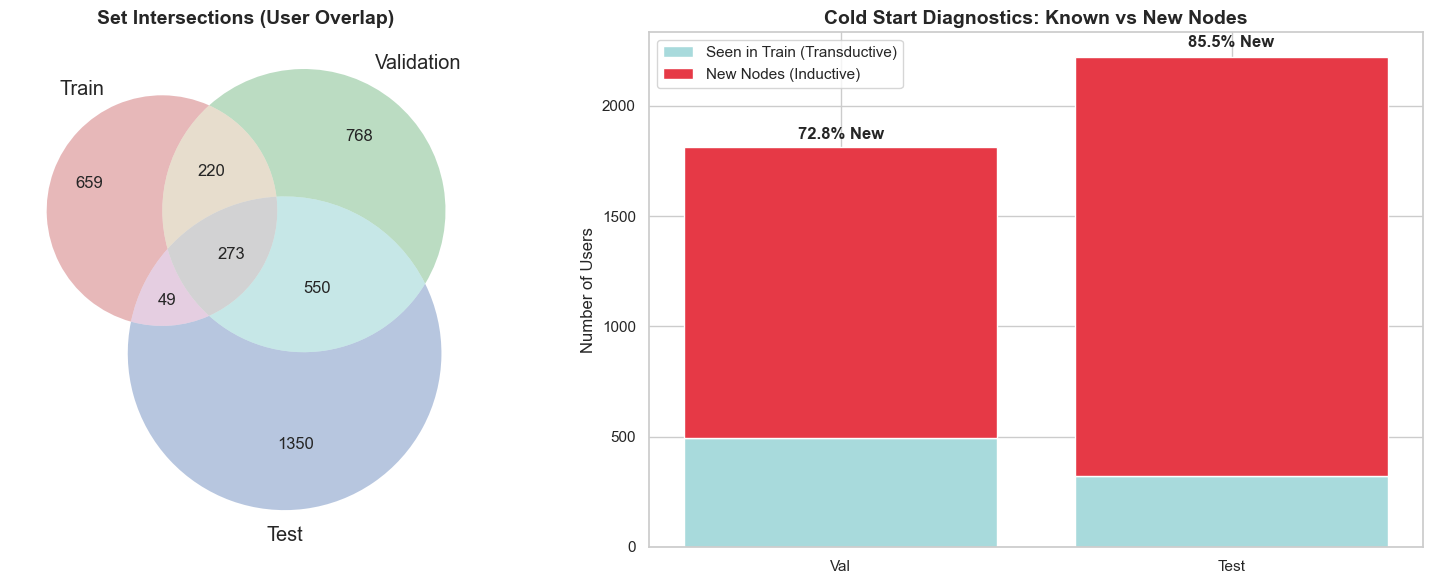


[3] Edge Duplicates Analysis
Found 77 duplicate edges between Train-Val
Found 9 duplicate edges between Train-Test
Found 355 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


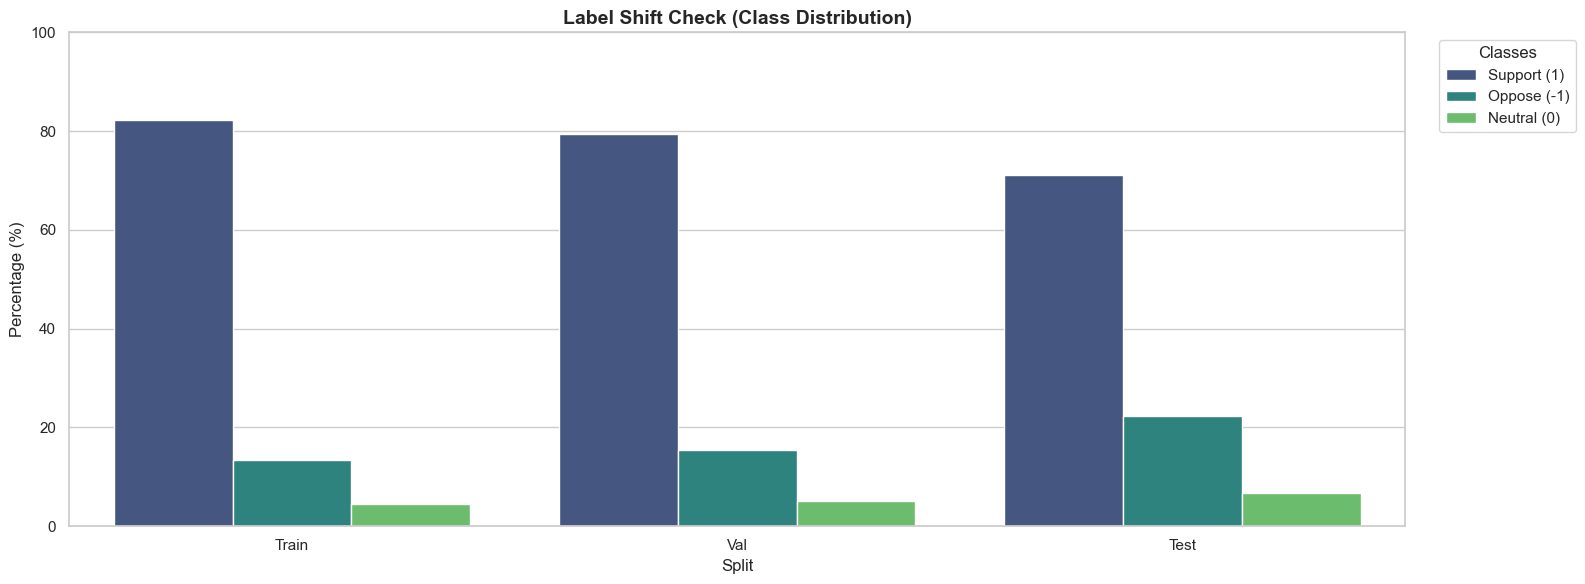

Epoch 00 | Loss(avg): 1.2863 | Val macro-F1(4): 0.2998 | Val link-F1: 0.4141 | Val pol-macroF1: 0.2946
Epoch 01 | Loss(avg): 1.0637 | Val macro-F1(4): 0.3055 | Val link-F1: 0.4390 | Val pol-macroF1: 0.2950
Epoch 02 | Loss(avg): 1.0473 | Val macro-F1(4): 0.3063 | Val link-F1: 0.4432 | Val pol-macroF1: 0.2951
Epoch 03 | Loss(avg): 1.0327 | Val macro-F1(4): 0.3066 | Val link-F1: 0.4444 | Val pol-macroF1: 0.2951
Epoch 04 | Loss(avg): 1.0242 | Val macro-F1(4): 0.3068 | Val link-F1: 0.4446 | Val pol-macroF1: 0.2951
Epoch 05 | Loss(avg): 1.0243 | Val macro-F1(4): 0.3067 | Val link-F1: 0.4448 | Val pol-macroF1: 0.2951
Epoch 06 | Loss(avg): 1.0161 | Val macro-F1(4): 0.3068 | Val link-F1: 0.4437 | Val pol-macroF1: 0.2951
Epoch 07 | Loss(avg): 1.0081 | Val macro-F1(4): 0.3071 | Val link-F1: 0.4453 | Val pol-macroF1: 0.2951
Epoch 08 | Loss(avg): 1.0005 | Val macro-F1(4): 0.3092 | Val link-F1: 0.4475 | Val pol-macroF1: 0.2952
Epoch 09 | Loss(avg): 0.9918 | Val macro-F1(4): 0.3174 | Val link-F1: 0.4

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.2478
Test link-F1 (existence): 0.1922
Test polarity macro-F1 on TP edges: 0.3176

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.68      0.96      0.80     50186
      Oppose       0.14      0.07      0.10      5602
     Neutral       0.00      0.00      0.00      1664
     Support       0.44      0.06      0.10     17827

    accuracy                           0.66     75279
   macro avg       0.32      0.27      0.25     75279
weighted avg       0.57      0.66      0.56     75279


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.27      0.58      0.37       691
     Neutral       0.00      0.00      0.00       228
     Support       0.71      0.50      0.59      1984

    accuracy                           0.48      2903
   macro avg       0.33      0.36      0.32      

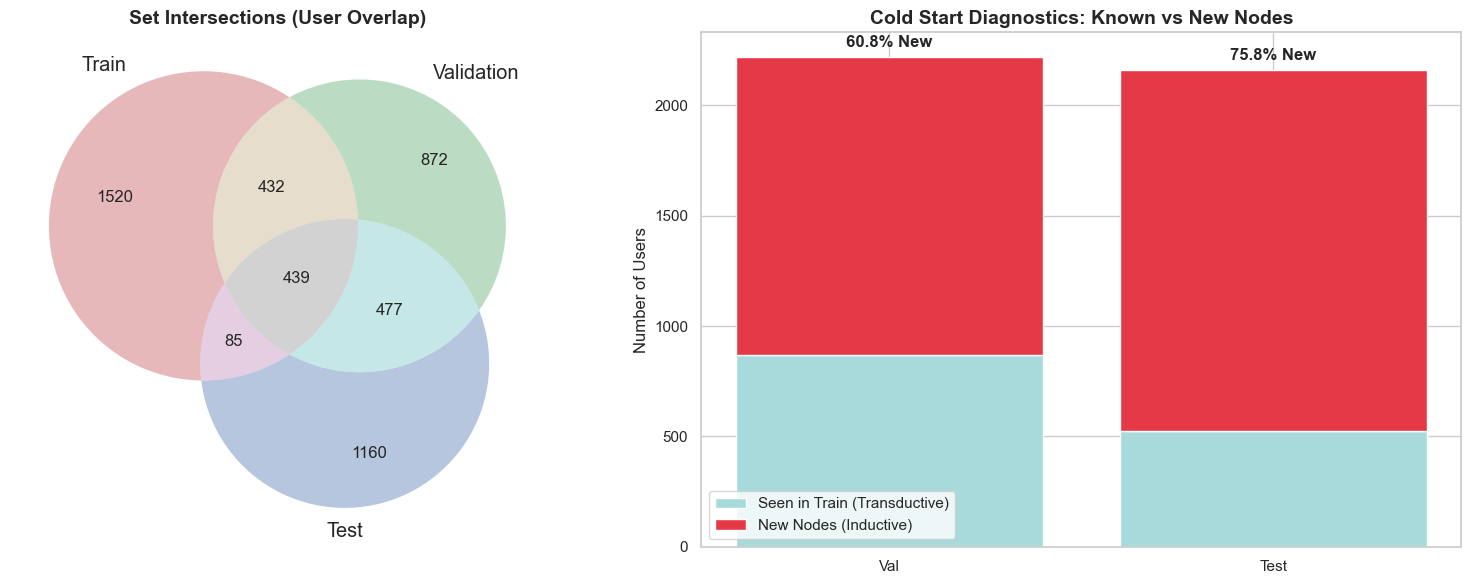


[3] Edge Duplicates Analysis
Found 364 duplicate edges between Train-Val
Found 16 duplicate edges between Train-Test
Found 363 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


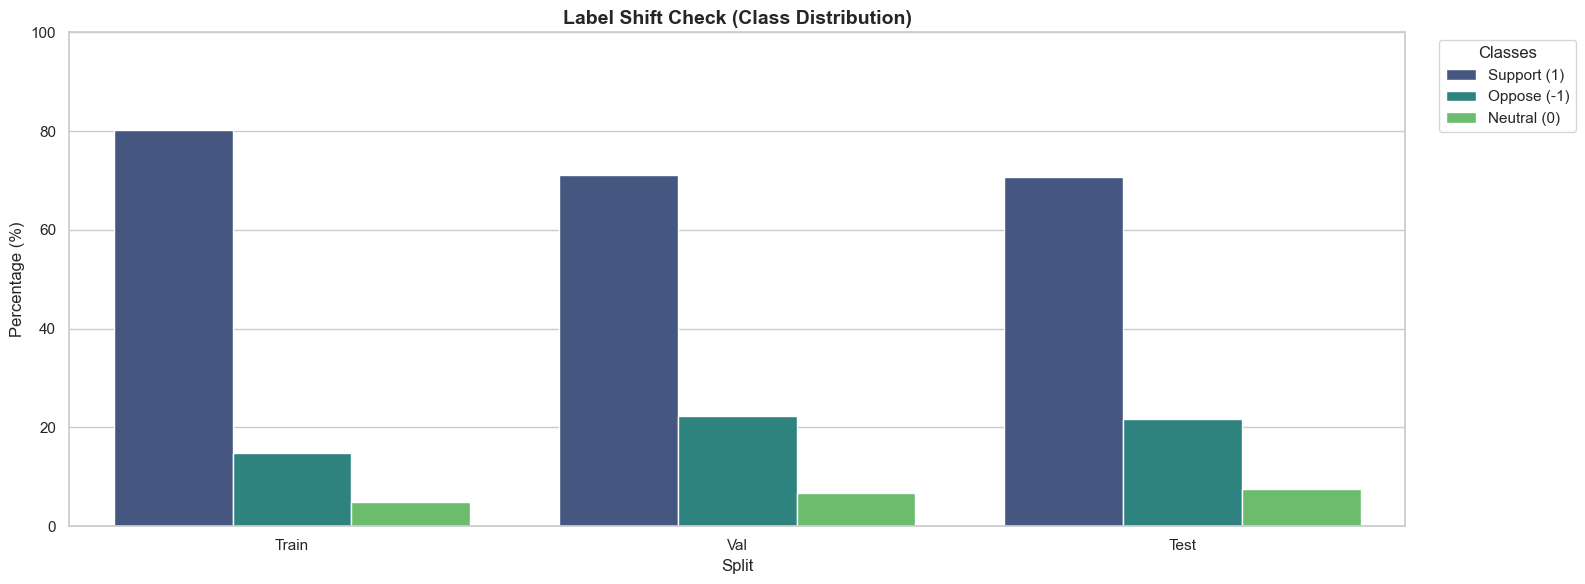

Epoch 00 | Loss(avg): 1.1133 | Val macro-F1(4): 0.4471 | Val link-F1: 0.8559 | Val pol-macroF1: 0.3369
Epoch 01 | Loss(avg): 1.0729 | Val macro-F1(4): 0.4791 | Val link-F1: 0.8634 | Val pol-macroF1: 0.3819
Epoch 02 | Loss(avg): 1.0569 | Val macro-F1(4): 0.4703 | Val link-F1: 0.8569 | Val pol-macroF1: 0.3717
Epoch 03 | Loss(avg): 1.0422 | Val macro-F1(4): 0.4923 | Val link-F1: 0.8666 | Val pol-macroF1: 0.4005
Epoch 04 | Loss(avg): 1.0388 | Val macro-F1(4): 0.4876 | Val link-F1: 0.8643 | Val pol-macroF1: 0.3942
Epoch 05 | Loss(avg): 1.0372 | Val macro-F1(4): 0.4839 | Val link-F1: 0.8607 | Val pol-macroF1: 0.3905
Epoch 06 | Loss(avg): 1.0213 | Val macro-F1(4): 0.4795 | Val link-F1: 0.8502 | Val pol-macroF1: 0.3908
Epoch 07 | Loss(avg): 1.0143 | Val macro-F1(4): 0.4832 | Val link-F1: 0.8449 | Val pol-macroF1: 0.3993
Epoch 08 | Loss(avg): 1.0087 | Val macro-F1(4): 0.4818 | Val link-F1: 0.8444 | Val pol-macroF1: 0.3980
Early stopping. Best Val macro-F1(4): 0.4923


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3497
Test link-F1 (existence): 0.5776
Test polarity macro-F1 on TP edges: 0.3253

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.88      0.83     39160
      Oppose       0.19      0.36      0.25      4265
     Neutral       0.00      0.00      0.00      1490
     Support       0.52      0.24      0.33     13825

    accuracy                           0.67     58740
   macro avg       0.37      0.37      0.35     58740
weighted avg       0.66      0.67      0.65     58740


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.26      0.74      0.39      2078
     Neutral       0.00      0.00      0.00       653
     Support       0.82      0.46      0.59      7083

    accuracy                           0.49      9814
   macro avg       0.36      0.40      0.33      

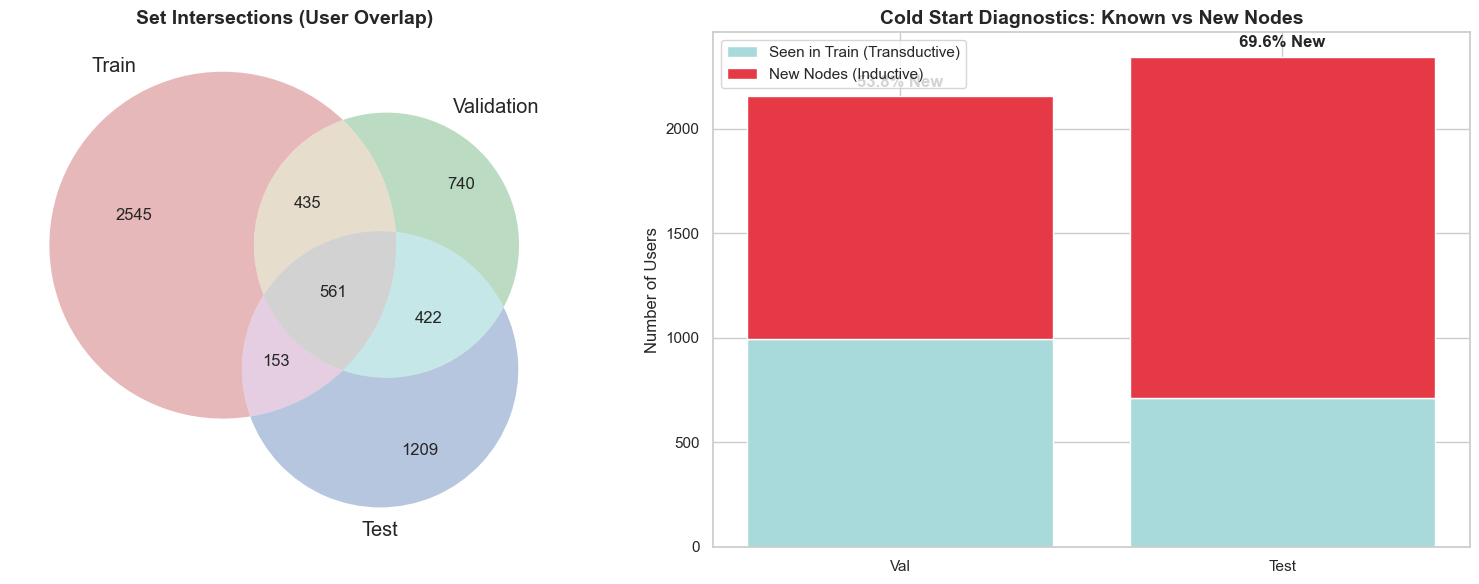


[3] Edge Duplicates Analysis
Found 376 duplicate edges between Train-Val
Found 50 duplicate edges between Train-Test
Found 333 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


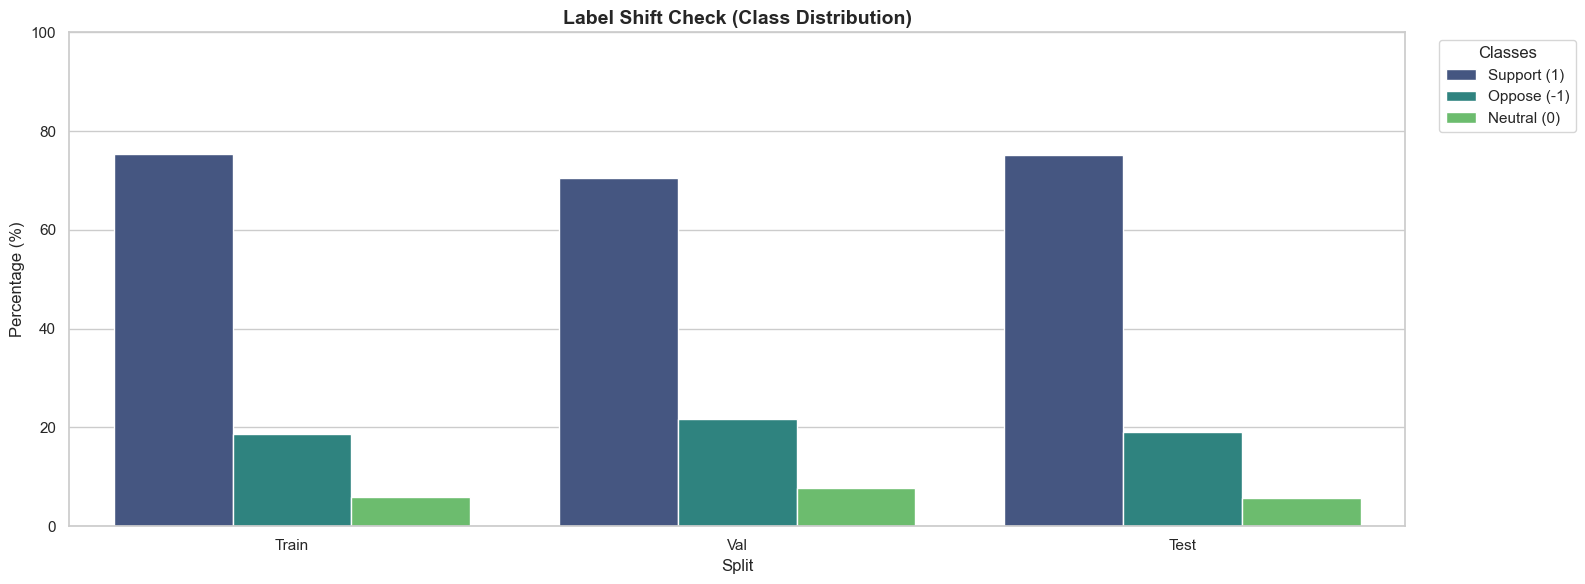

Epoch 00 | Loss(avg): 1.1196 | Val macro-F1(4): 0.4791 | Val link-F1: 0.8153 | Val pol-macroF1: 0.4126
Epoch 01 | Loss(avg): 1.0989 | Val macro-F1(4): 0.4937 | Val link-F1: 0.8229 | Val pol-macroF1: 0.4324
Epoch 02 | Loss(avg): 1.0872 | Val macro-F1(4): 0.4847 | Val link-F1: 0.8172 | Val pol-macroF1: 0.4215
Epoch 03 | Loss(avg): 1.0802 | Val macro-F1(4): 0.4694 | Val link-F1: 0.8196 | Val pol-macroF1: 0.3929
Epoch 04 | Loss(avg): 1.0750 | Val macro-F1(4): 0.4710 | Val link-F1: 0.8046 | Val pol-macroF1: 0.4069
Epoch 05 | Loss(avg): 1.0667 | Val macro-F1(4): 0.4654 | Val link-F1: 0.8202 | Val pol-macroF1: 0.3877
Epoch 06 | Loss(avg): 1.0631 | Val macro-F1(4): 0.4436 | Val link-F1: 0.8148 | Val pol-macroF1: 0.3547
Early stopping. Best Val macro-F1(4): 0.4937


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3258
Test link-F1 (existence): 0.5472
Test polarity macro-F1 on TP edges: 0.2890

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.77      0.89      0.82     39432
      Oppose       0.16      0.37      0.22      3753
     Neutral       0.00      0.00      0.00      1135
     Support       0.54      0.17      0.26     14828

    accuracy                           0.66     59148
   macro avg       0.37      0.36      0.33     59148
weighted avg       0.66      0.66      0.63     59148


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.23      0.79      0.35      1763
     Neutral       0.00      0.00      0.00       495
     Support       0.84      0.37      0.51      6826

    accuracy                           0.43      9084
   macro avg       0.36      0.39      0.29      

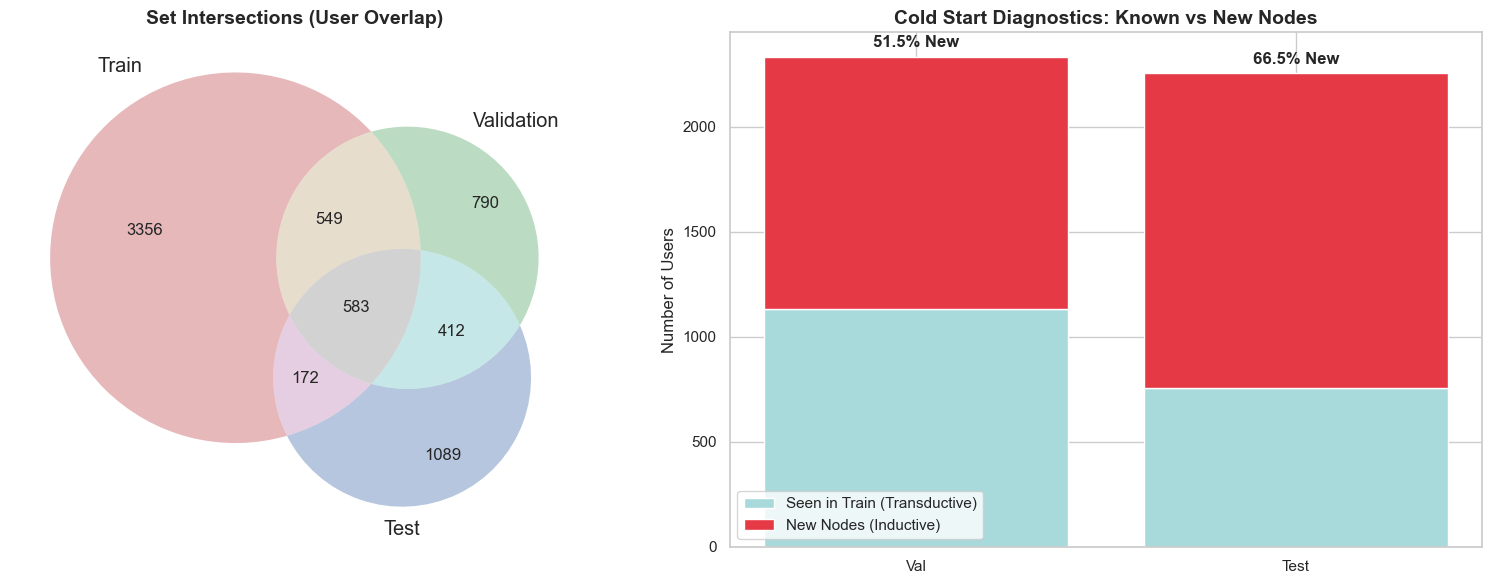


[3] Edge Duplicates Analysis
Found 373 duplicate edges between Train-Val
Found 84 duplicate edges between Train-Test
Found 470 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


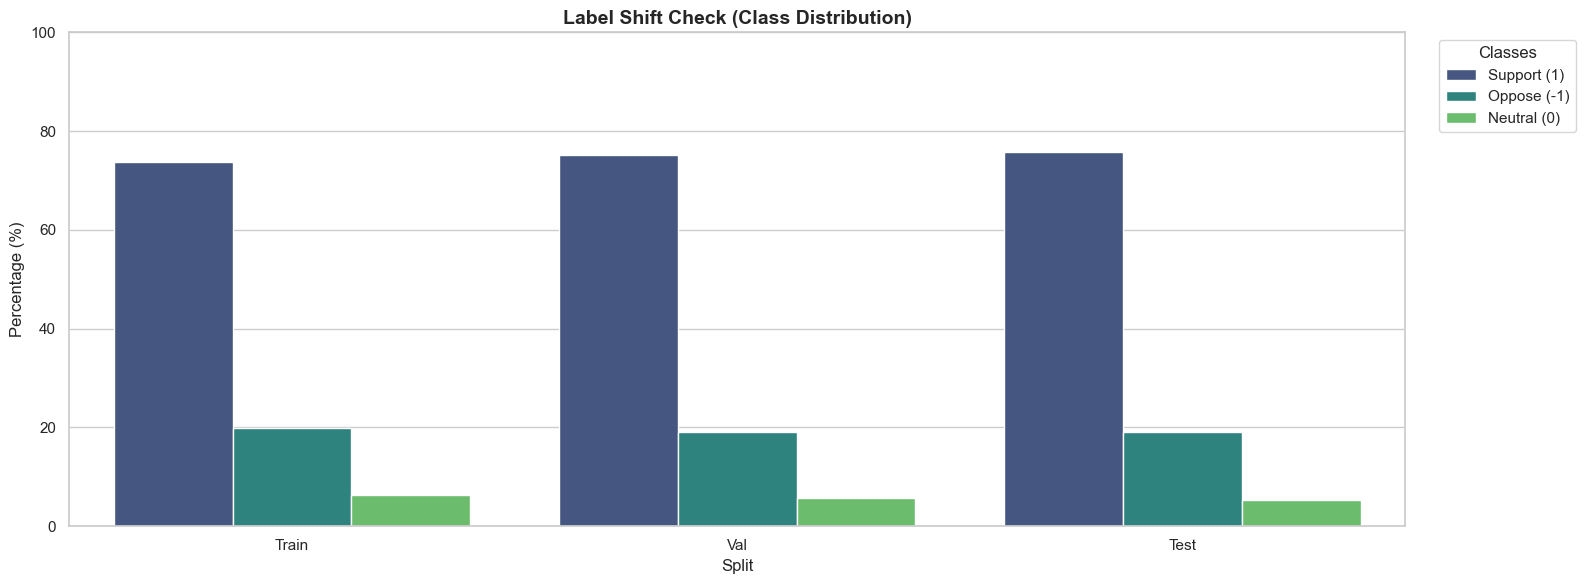

Epoch 00 | Loss(avg): 1.1329 | Val macro-F1(4): 0.4313 | Val link-F1: 0.8178 | Val pol-macroF1: 0.3339
Epoch 01 | Loss(avg): 1.1204 | Val macro-F1(4): 0.4396 | Val link-F1: 0.8227 | Val pol-macroF1: 0.3442
Epoch 02 | Loss(avg): 1.1150 | Val macro-F1(4): 0.4604 | Val link-F1: 0.8093 | Val pol-macroF1: 0.3854
Epoch 03 | Loss(avg): 1.1045 | Val macro-F1(4): 0.4638 | Val link-F1: 0.8186 | Val pol-macroF1: 0.3852
Epoch 04 | Loss(avg): 1.0942 | Val macro-F1(4): 0.4447 | Val link-F1: 0.8309 | Val pol-macroF1: 0.3474
Epoch 05 | Loss(avg): 1.0853 | Val macro-F1(4): 0.4239 | Val link-F1: 0.8308 | Val pol-macroF1: 0.3129
Epoch 06 | Loss(avg): 1.0789 | Val macro-F1(4): 0.4280 | Val link-F1: 0.8251 | Val pol-macroF1: 0.3240
Epoch 07 | Loss(avg): 1.0730 | Val macro-F1(4): 0.4172 | Val link-F1: 0.8053 | Val pol-macroF1: 0.3155
Epoch 08 | Loss(avg): 1.0628 | Val macro-F1(4): 0.4338 | Val link-F1: 0.8246 | Val pol-macroF1: 0.3336
Early stopping. Best Val macro-F1(4): 0.4638


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3200
Test link-F1 (existence): 0.5944
Test polarity macro-F1 on TP edges: 0.2417

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.92      0.85     40008
      Oppose       0.15      0.37      0.21      3803
     Neutral       0.00      0.00      0.00      1047
     Support       0.57      0.14      0.22     15154

    accuracy                           0.67     60012
   macro avg       0.38      0.36      0.32     60012
weighted avg       0.68      0.67      0.63     60012


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.19      0.78      0.31      1790
     Neutral       0.00      0.00      0.00       523
     Support       0.80      0.28      0.42      7545

    accuracy                           0.36      9858
   macro avg       0.33      0.35      0.24      

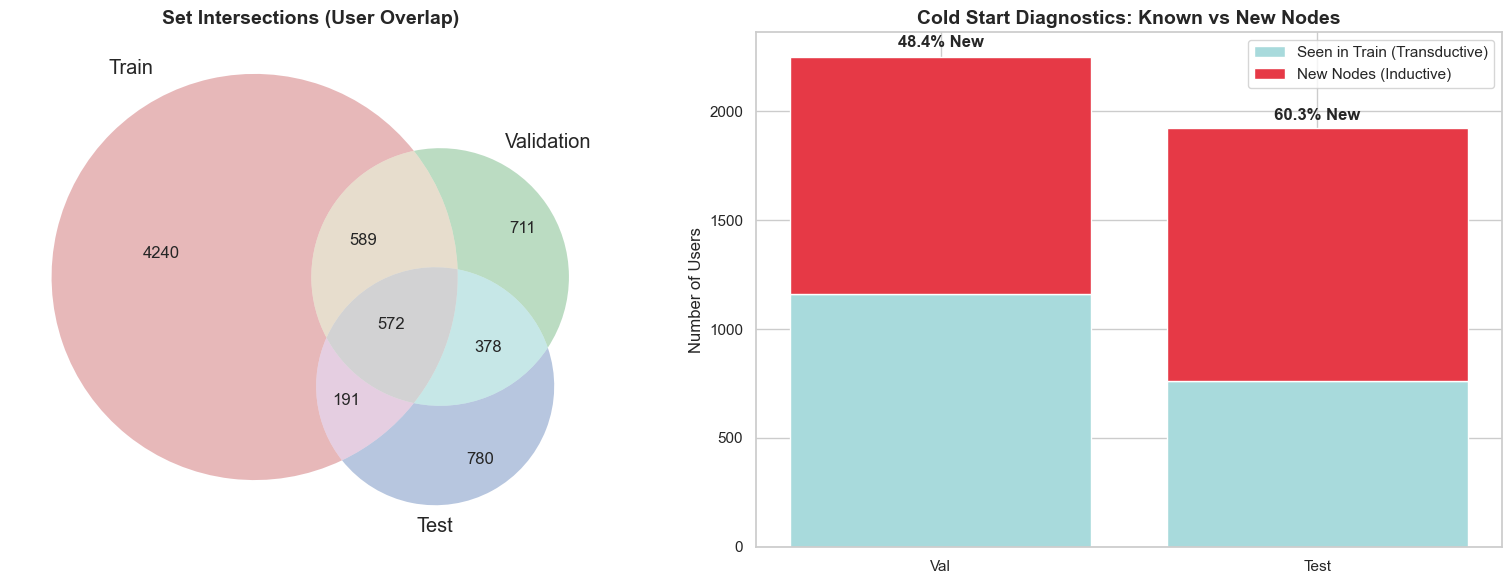


[3] Edge Duplicates Analysis
Found 527 duplicate edges between Train-Val
Found 153 duplicate edges between Train-Test
Found 478 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


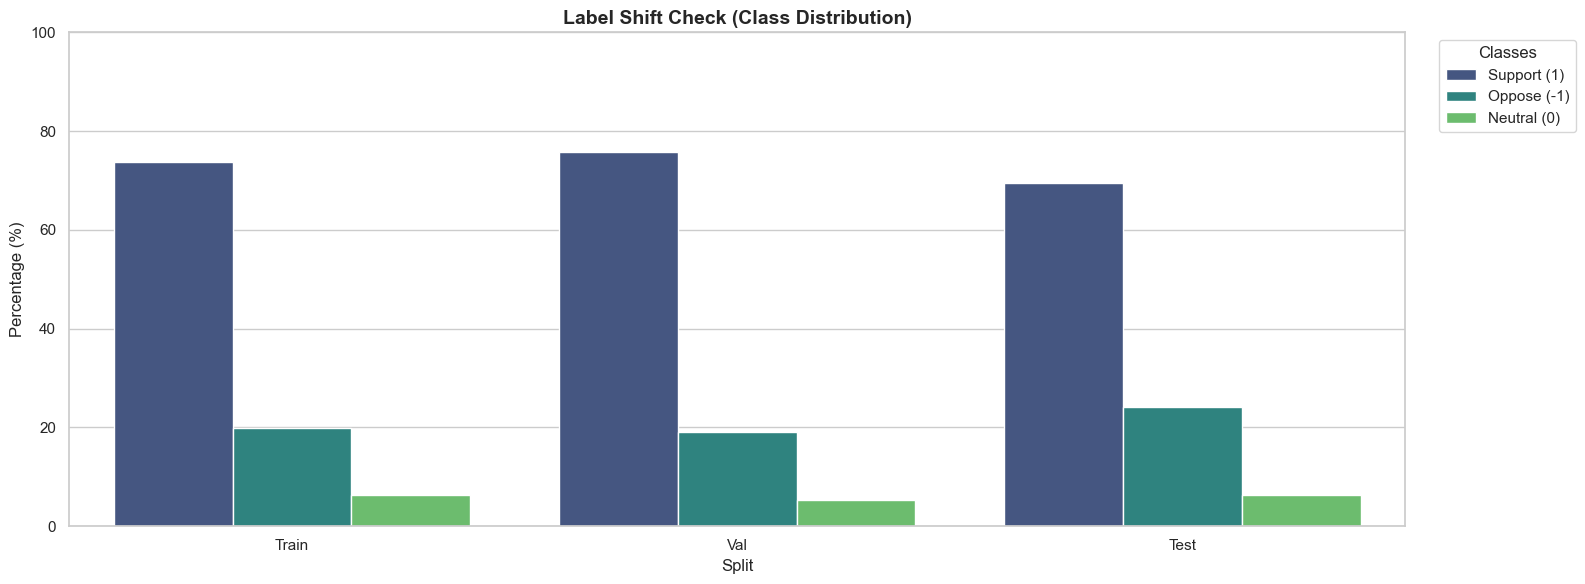

Epoch 00 | Loss(avg): 1.1310 | Val macro-F1(4): 0.4602 | Val link-F1: 0.8330 | Val pol-macroF1: 0.3722
Epoch 01 | Loss(avg): 1.1128 | Val macro-F1(4): 0.4649 | Val link-F1: 0.8351 | Val pol-macroF1: 0.3778
Epoch 02 | Loss(avg): 1.1039 | Val macro-F1(4): 0.4688 | Val link-F1: 0.8313 | Val pol-macroF1: 0.3882
Epoch 03 | Loss(avg): 1.0901 | Val macro-F1(4): 0.4504 | Val link-F1: 0.8336 | Val pol-macroF1: 0.3538
Epoch 04 | Loss(avg): 1.0856 | Val macro-F1(4): 0.4475 | Val link-F1: 0.8235 | Val pol-macroF1: 0.3564
Epoch 05 | Loss(avg): 1.0801 | Val macro-F1(4): 0.4579 | Val link-F1: 0.8168 | Val pol-macroF1: 0.3775
Epoch 06 | Loss(avg): 1.0666 | Val macro-F1(4): 0.4181 | Val link-F1: 0.8009 | Val pol-macroF1: 0.3217
Epoch 07 | Loss(avg): 1.0616 | Val macro-F1(4): 0.4236 | Val link-F1: 0.8167 | Val pol-macroF1: 0.3191
Early stopping. Best Val macro-F1(4): 0.4688


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3291
Test link-F1 (existence): 0.5843
Test polarity macro-F1 on TP edges: 0.2690

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.91      0.84     32286
      Oppose       0.18      0.33      0.23      3895
     Neutral       0.00      0.00      0.00      1034
     Support       0.52      0.16      0.25     11214

    accuracy                           0.67     48429
   macro avg       0.37      0.35      0.33     48429
weighted avg       0.65      0.67      0.64     48429


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.24      0.70      0.36      1838
     Neutral       0.00      0.00      0.00       480
     Support       0.73      0.33      0.45      5538

    accuracy                           0.39      7856
   macro avg       0.32      0.34      0.27      

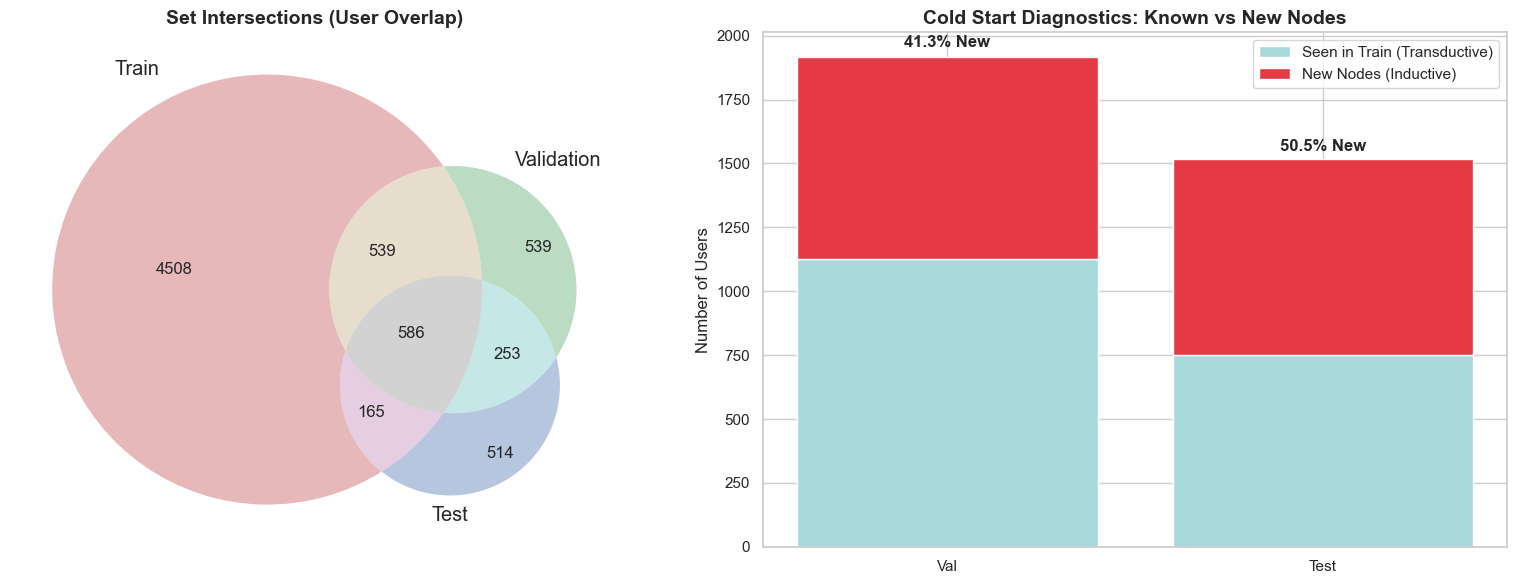


[3] Edge Duplicates Analysis
Found 590 duplicate edges between Train-Val
Found 84 duplicate edges between Train-Test
Found 251 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


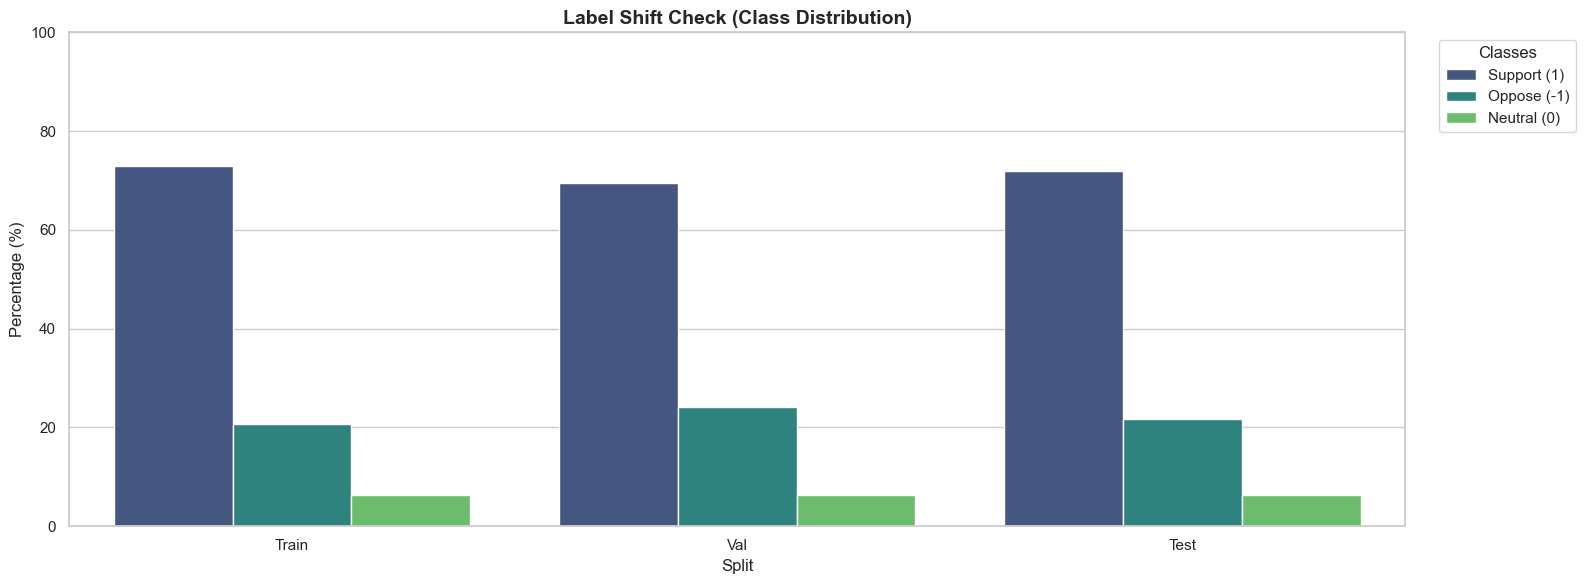

Epoch 00 | Loss(avg): 1.1175 | Val macro-F1(4): 0.4754 | Val link-F1: 0.8317 | Val pol-macroF1: 0.3972
Epoch 01 | Loss(avg): 1.1049 | Val macro-F1(4): 0.4878 | Val link-F1: 0.8532 | Val pol-macroF1: 0.4026
Epoch 02 | Loss(avg): 1.0963 | Val macro-F1(4): 0.4685 | Val link-F1: 0.8343 | Val pol-macroF1: 0.3819
Epoch 03 | Loss(avg): 1.0864 | Val macro-F1(4): 0.4577 | Val link-F1: 0.8358 | Val pol-macroF1: 0.3650
Epoch 04 | Loss(avg): 1.0807 | Val macro-F1(4): 0.4572 | Val link-F1: 0.8209 | Val pol-macroF1: 0.3767
Epoch 05 | Loss(avg): 1.0742 | Val macro-F1(4): 0.4331 | Val link-F1: 0.8191 | Val pol-macroF1: 0.3348
Epoch 06 | Loss(avg): 1.0673 | Val macro-F1(4): 0.4283 | Val link-F1: 0.8350 | Val pol-macroF1: 0.3184
Early stopping. Best Val macro-F1(4): 0.4878


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3223
Test link-F1 (existence): 0.6136
Test polarity macro-F1 on TP edges: 0.2346

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.79      0.92      0.85     20968
      Oppose       0.17      0.42      0.24      2285
     Neutral       0.00      0.00      0.00       664
     Support       0.60      0.12      0.19      7535

    accuracy                           0.67     31452
   macro avg       0.39      0.36      0.32     31452
weighted avg       0.68      0.67      0.63     31452


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.22      0.84      0.35      1139
     Neutral       0.00      0.00      0.00       336
     Support       0.78      0.22      0.35      3897

    accuracy                           0.34      5372
   macro avg       0.34      0.35      0.23      

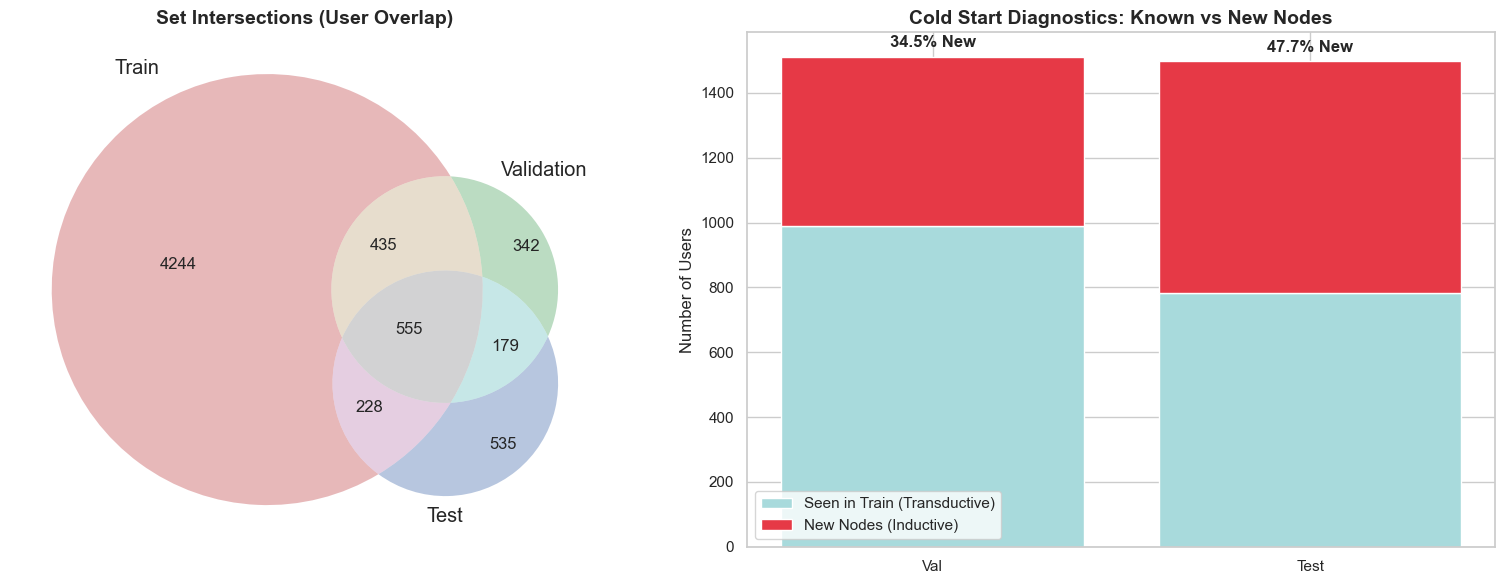


[3] Edge Duplicates Analysis
Found 322 duplicate edges between Train-Val
Found 219 duplicate edges between Train-Test
Found 377 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


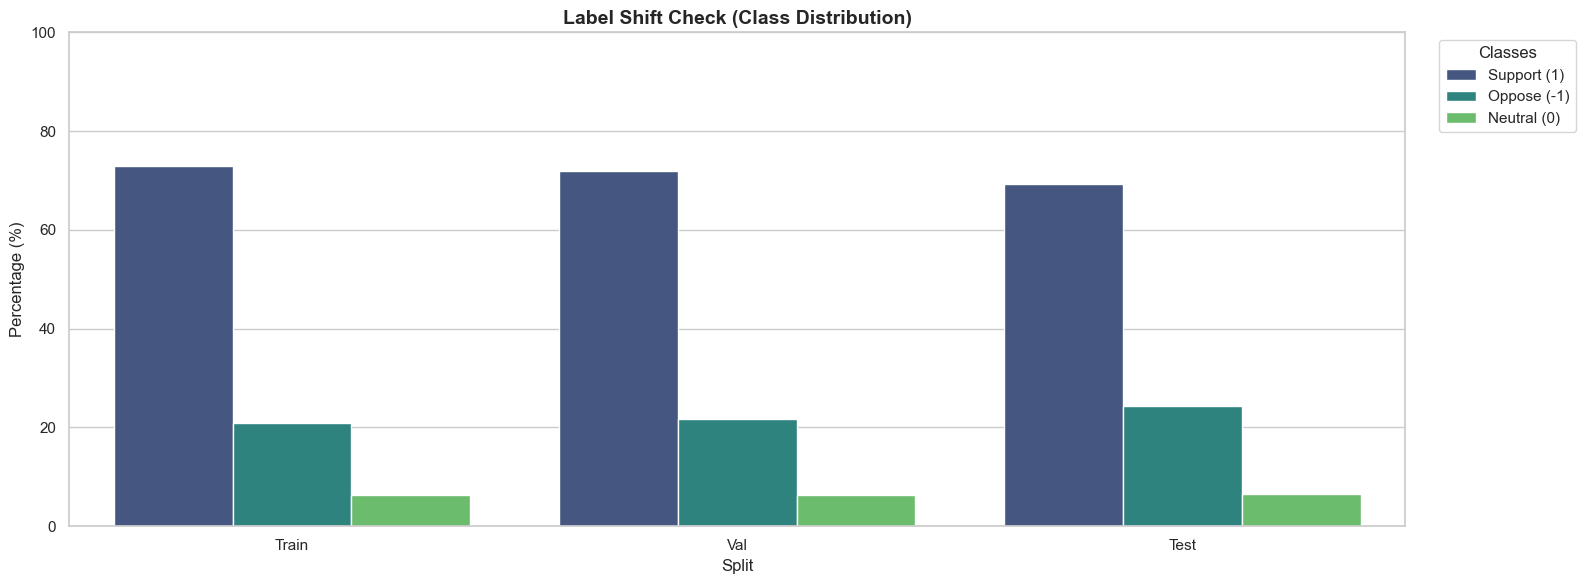

Epoch 00 | Loss(avg): 1.1219 | Val macro-F1(4): 0.4498 | Val link-F1: 0.8490 | Val pol-macroF1: 0.3444
Epoch 01 | Loss(avg): 1.1049 | Val macro-F1(4): 0.3812 | Val link-F1: 0.8567 | Val pol-macroF1: 0.2338
Epoch 02 | Loss(avg): 1.1013 | Val macro-F1(4): 0.3779 | Val link-F1: 0.8362 | Val pol-macroF1: 0.2384
Epoch 03 | Loss(avg): 1.0920 | Val macro-F1(4): 0.3733 | Val link-F1: 0.8397 | Val pol-macroF1: 0.2298
Epoch 04 | Loss(avg): 1.0875 | Val macro-F1(4): 0.3680 | Val link-F1: 0.8417 | Val pol-macroF1: 0.2193
Epoch 05 | Loss(avg): 1.0821 | Val macro-F1(4): 0.3658 | Val link-F1: 0.8344 | Val pol-macroF1: 0.2184
Early stopping. Best Val macro-F1(4): 0.4498


c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3174
Test link-F1 (existence): 0.5946
Test polarity macro-F1 on TP edges: 0.2328

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.92      0.85     22946
      Oppose       0.18      0.38      0.25      2784
     Neutral       0.00      0.00      0.00       747
     Support       0.52      0.11      0.18      7942

    accuracy                           0.67     34419
   macro avg       0.37      0.35      0.32     34419
weighted avg       0.66      0.67      0.63     34419


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.24      0.78      0.37      1352
     Neutral       0.00      0.00      0.00       364
     Support       0.69      0.22      0.33      3909

    accuracy                           0.34      5625
   macro avg       0.31      0.33      0.23      

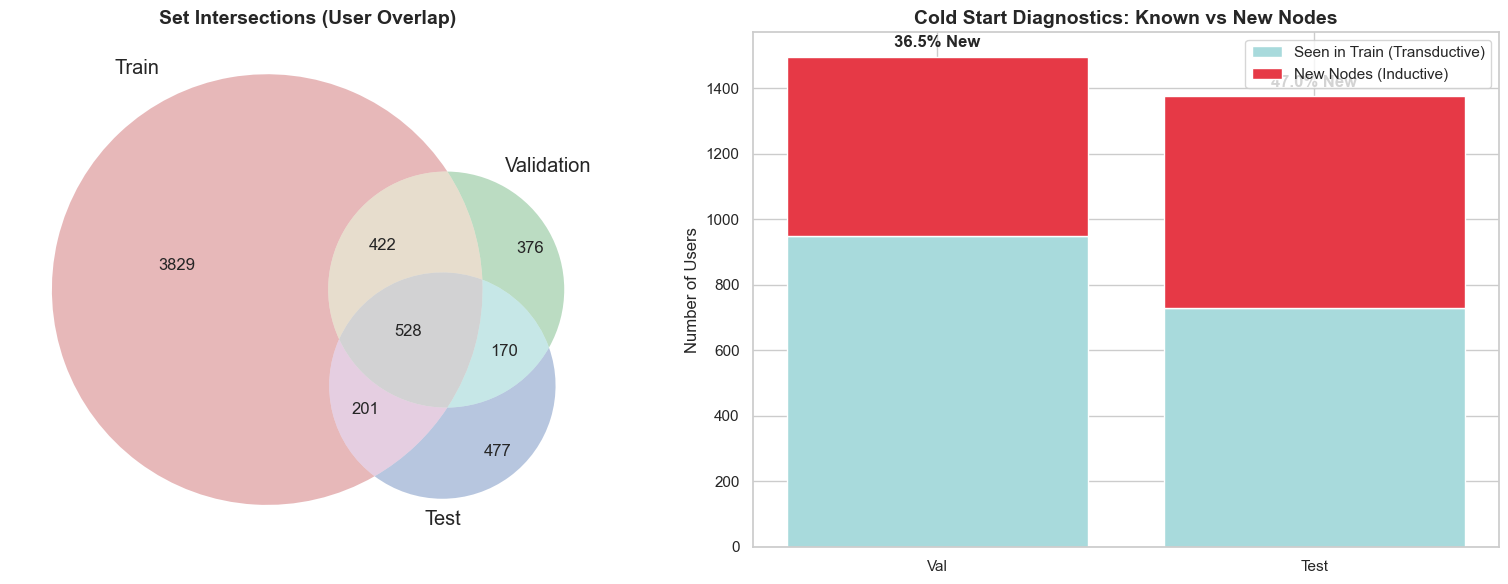


[3] Edge Duplicates Analysis
Found 552 duplicate edges between Train-Val
Found 248 duplicate edges between Train-Test
Found 443 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


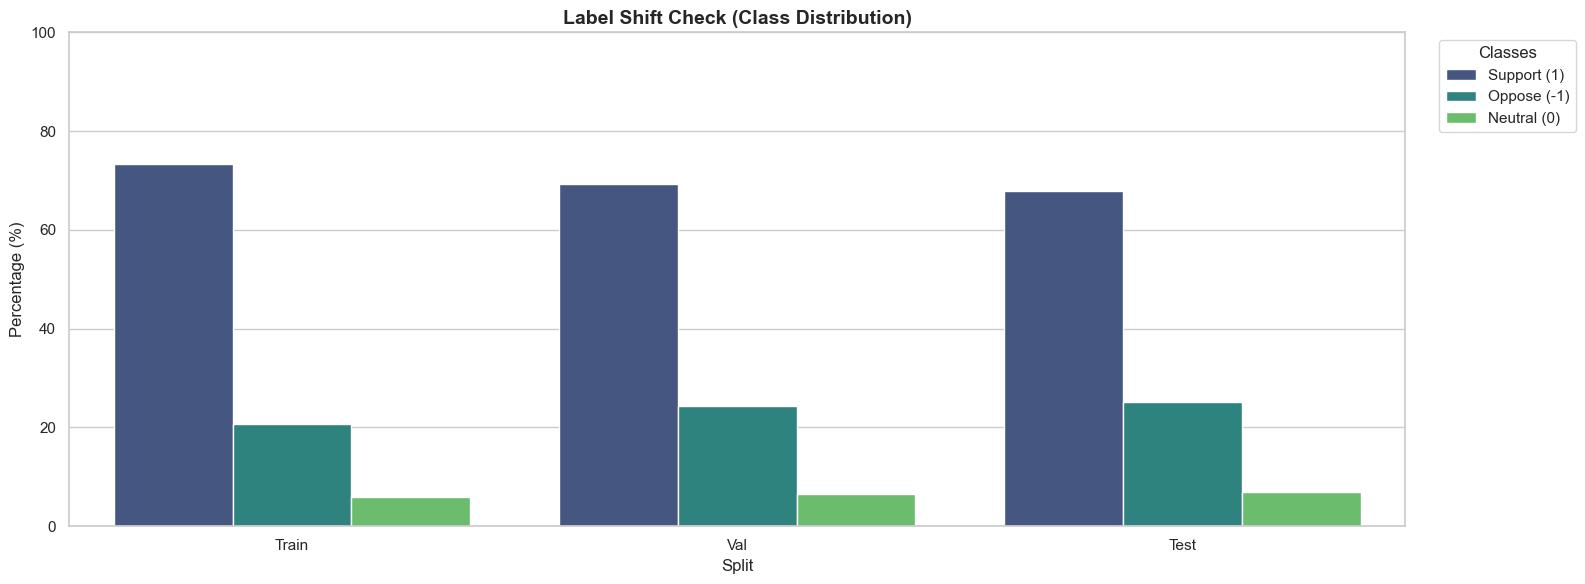

Epoch 00 | Loss(avg): 1.1142 | Val macro-F1(4): 0.4115 | Val link-F1: 0.8288 | Val pol-macroF1: 0.2960
Epoch 01 | Loss(avg): 1.1055 | Val macro-F1(4): 0.4425 | Val link-F1: 0.8418 | Val pol-macroF1: 0.3389
Epoch 02 | Loss(avg): 1.0903 | Val macro-F1(4): 0.4368 | Val link-F1: 0.8458 | Val pol-macroF1: 0.3262
Epoch 03 | Loss(avg): 1.0877 | Val macro-F1(4): 0.4076 | Val link-F1: 0.8417 | Val pol-macroF1: 0.2830
Epoch 04 | Loss(avg): 1.0807 | Val macro-F1(4): 0.3723 | Val link-F1: 0.8368 | Val pol-macroF1: 0.2302
Epoch 05 | Loss(avg): 1.0797 | Val macro-F1(4): 0.4098 | Val link-F1: 0.8340 | Val pol-macroF1: 0.2906


KeyboardInterrupt: 

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

model = HierGNN(feature_dim=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

link_weights = torch.tensor([0.85, 1.22], dtype=torch.float).to(device)  # Example weights
pol_weights = torch.tensor([1.25, 2.32, 0.67], dtype=torch.float).to(device)  # Example weights

# Running message-passing graph built from accumulated TRAIN POSITIVE edges
train_edge_index = torch.empty((2, 0), dtype=torch.long)
dates_edge_index = torch.empty((0), dtype=torch.long)

for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(get_sliding_windows(X, y_pos, dates)):
    print(f"\n--- Window {i} ---")

    # ---------------------------------------------------------
    # 1. Build the message-passing graph from TRAIN POSITIVE edges only
    # ---------------------------------------------------------
    # Append current window's positive training edges to the running edge_index
    train_edge_index = torch.cat([train_edge_index, X_tr.t().contiguous()], dim=1)  # [2, E_total_pos]
    dates_edge_index = torch.cat([dates_edge_index, torch.tensor(dates_tr, dtype=torch.long)])

    # Extract node features from training edges
    x_features = extract_node_features(
        edge_index=train_edge_index,
        edge_dates_int=dates_edge_index,
        num_nodes=num_users
    )

    data = Data(x=x_features, edge_index=train_edge_index)
    analyze_split_statistics(X_tr, y_tr, X_va, y_va, X_te, y_te)

    # ---------------------------------------------------------
    # 2. Negative sampling
    # ---------------------------------------------------------
    neg_ratio = 2
    sampler = CandidateCentricSampler([X_tr, X_va, X_te])

    # Negatives for each split (no_vote = 0)
    X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr, num_users, ratio=neg_ratio, seed=42)
    X_val_neg, y_val_neg = sampler.sample_negatives(X_va, num_users, ratio=neg_ratio, seed=123)
    X_test_neg, y_test_neg = sampler.sample_negatives(X_te, num_users, ratio=neg_ratio, seed=999)

    # 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
    X_tr_4 = torch.cat([X_tr,  X_tr_neg],  dim=0)
    y_tr_4 = torch.cat([y_tr,  y_tr_neg],  dim=0)

    X_val_4 = torch.cat([X_va, X_val_neg], dim=0)
    y_val_4 = torch.cat([y_va, y_val_neg], dim=0)

    X_test_4 = torch.cat([X_te, X_test_neg], dim=0)
    y_test_4 = torch.cat([y_te, y_test_neg], dim=0)

    # ---------------------------------------------------------
    # 3. Weights per class
    # ---------------------------------------------------------
    # Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
    y_tr_link = (y_tr_4 != 0).long()
    link_counts = torch.bincount(y_tr_link, minlength=2).float()
    link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
    alpha = 0.5
    link_weights = link_base_w.pow(alpha).to(device)

    # Polarity labels from positives only: {1,2,3} -> {0,1,2}
    y_tr_pol = (y_tr - 1).long()
    pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
    pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
    pol_weights = pol_base_w.pow(alpha).to(device)

    # ---------------------------------------------------------
    # 4. LinkNeighborLoader
    # ---------------------------------------------------------
    # Message passing happens on data.edge_index (TRAIN POS edges only)
    train_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_tr_4.t().contiguous(),
        edge_label=y_tr_4,
        batch_size=2048,
        shuffle=True
    )

    val_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_val_4.t().contiguous(),
        edge_label=y_val_4,
        batch_size=4096,
        shuffle=False
    )

    test_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_test_4.t().contiguous(),
        edge_label=y_test_4,
        batch_size=4096,
        shuffle=False
    )

    # ---------------------------------------------------------
    # 5. Training loop
    # ---------------------------------------------------------
    best_state = training_loop(
        model, optimizer,
        train_loader, val_loader,
        device,
        link_weights, pol_weights,
        patience=5,
        lambda_pol=1.0,
        num_epochs=50
    )
    model.load_state_dict(best_state)

    # ---------------------------------------------------------
    # 6. Final evaluation on test set
    # ---------------------------------------------------------
    test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(model, test_loader, device, report=True)

    print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
    print(f"Test link-F1 (existence): {test_link_f1:.4f}")
    print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
    print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
    print(classification_report(
        y_true_4, y_pred_4,
        target_names=["NoVote", "Oppose", "Neutral", "Support"],
        digits=2
    ))

    print("\nVote polarity report on true-positive links where model predicts Voted:")
    print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")


    train_edge_index = torch.cat([train_edge_index, X_va.t().contiguous()], dim=1)
    dates_edge_index = torch.cat([dates_edge_index, torch.tensor(dates_va, dtype=torch.long)])
    train_edge_index = torch.cat([train_edge_index, X_te.t().contiguous()], dim=1)
    dates_edge_index = torch.cat([dates_edge_index, torch.tensor(dates_te, dtype=torch.long)])
